In [1]:
!pip install torch torchvision matplotlib


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)


In [4]:
train_dataset = FashionMNIST('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())

test_dataset = FashionMNIST('./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.95MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.54MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Thêm định nghĩa batch_size ở đây
batch_size = 64

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 54000
Validation size: 6000
Test size: 10000


(a) Xây dựng các mô hình thành phần

In [6]:
class MLP_1layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_1layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)

        # Khởi tạo trọng số
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        return x

class MLP_2layers(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_2layers, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        self.layer2 = nn.Linear(output_dims, output_dims)

        # Khởi tạo trọng số
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x

(b) Khởi tạo các module thành phần

In [ ]:
# Khởi tạo các thành phần mạng
first = MLP_2layers(input_dims=784, output_dims=128)    # Mô hình đầu tiên: 2 lớp
second = MLP_2layers(input_dims=128, output_dims=128)   # Mô hình thứ hai: 2 lớp
third = MLP_2layers(input_dims=128, output_dims=128)    # Mô hình thứ ba: 2 lớp
fourth = MLP_1layer(input_dims=128, output_dims=128)    # Mô hình thứ tư: 1 lớp

# Thiết lập learning rate và hàm mất mát
lr = 1e-2
criterion = nn.CrossEntropyLoss()


(c) Giai đoạn 1 - Huấn luyện chỉ với thành phần đầu tiên

In [9]:
# Mô hình: Thành phần first + lớp đầu ra
model = nn.Sequential(
    first,                        # Thành phần first: MLP_2layers
    nn.Linear(128, 10)            # Lớp đầu ra: 128 -> 10 nhãn
).to(device)

# Khởi tạo optimizer và hàm mất mát
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


In [10]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    # Chế độ huấn luyện
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    # Chế độ đánh giá
    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    # In kết quả sau mỗi epoch
    print(f"EPOCH {epoch + 1}/{epochs}, "
          f"Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")


EPOCH 1/100, Train_Loss: 2.2945, Train_Acc: 0.1334, Validation Loss: 2.2802, Val_Acc: 0.2598
EPOCH 2/100, Train_Loss: 2.2586, Train_Acc: 0.2578, Validation Loss: 2.2265, Val_Acc: 0.3155
EPOCH 3/100, Train_Loss: 2.1496, Train_Acc: 0.3626, Validation Loss: 2.0360, Val_Acc: 0.4390
EPOCH 4/100, Train_Loss: 1.8703, Train_Acc: 0.4302, Validation Loss: 1.7300, Val_Acc: 0.3747
EPOCH 5/100, Train_Loss: 1.6135, Train_Acc: 0.4995, Validation Loss: 1.5219, Val_Acc: 0.5190
EPOCH 6/100, Train_Loss: 1.4266, Train_Acc: 0.5530, Validation Loss: 1.3559, Val_Acc: 0.5510
EPOCH 7/100, Train_Loss: 1.2782, Train_Acc: 0.5857, Validation Loss: 1.2293, Val_Acc: 0.5982
EPOCH 8/100, Train_Loss: 1.1682, Train_Acc: 0.6079, Validation Loss: 1.1360, Val_Acc: 0.6160
EPOCH 9/100, Train_Loss: 1.0851, Train_Acc: 0.6251, Validation Loss: 1.0664, Val_Acc: 0.6142
EPOCH 10/100, Train_Loss: 1.0199, Train_Acc: 0.6387, Validation Loss: 1.0059, Val_Acc: 0.6373
EPOCH 11/100, Train_Loss: 0.9658, Train_Acc: 0.6538, Validation Loss:

(d) Giai đoạn 2 - Thêm thành phần thứ hai

In [11]:
# Cố định trọng số của thành phần first
for param in first.parameters():
    param.requires_grad = False  # Không cho phép cập nhật trọng số

# Xây dựng mô hình: Thêm thành phần second và một lớp đầu ra
model = nn.Sequential(
    first,                # Thành phần first đã được huấn luyện
    second,               # Thành phần second mới thêm vào
    nn.Linear(128, 10)    # Lớp đầu ra: chuyển 128 -> 10 nhãn
).to(device)

# Khởi tạo optimizer và hàm mất mát
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


In [12]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    # Chế độ huấn luyện
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    # Chế độ đánh giá
    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    # In kết quả sau mỗi epoch
    print(f"EPOCH {epoch + 1}/{epochs}, "
          f"Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")


EPOCH 1/100, Train_Loss: 2.3017, Train_Acc: 0.1086, Validation Loss: 2.2998, Val_Acc: 0.1020
EPOCH 2/100, Train_Loss: 2.2964, Train_Acc: 0.1273, Validation Loss: 2.2936, Val_Acc: 0.1003
EPOCH 3/100, Train_Loss: 2.2885, Train_Acc: 0.1595, Validation Loss: 2.2826, Val_Acc: 0.2685
EPOCH 4/100, Train_Loss: 2.2725, Train_Acc: 0.1969, Validation Loss: 2.2592, Val_Acc: 0.3448
EPOCH 5/100, Train_Loss: 2.2310, Train_Acc: 0.2619, Validation Loss: 2.1919, Val_Acc: 0.2758
EPOCH 6/100, Train_Loss: 2.1070, Train_Acc: 0.2966, Validation Loss: 1.9988, Val_Acc: 0.3737
EPOCH 7/100, Train_Loss: 1.8697, Train_Acc: 0.3563, Validation Loss: 1.7642, Val_Acc: 0.4423
EPOCH 8/100, Train_Loss: 1.6900, Train_Acc: 0.4424, Validation Loss: 1.6392, Val_Acc: 0.5558
EPOCH 9/100, Train_Loss: 1.5935, Train_Acc: 0.4935, Validation Loss: 1.5632, Val_Acc: 0.5172
EPOCH 10/100, Train_Loss: 1.5237, Train_Acc: 0.5277, Validation Loss: 1.4977, Val_Acc: 0.5263
EPOCH 11/100, Train_Loss: 1.4559, Train_Acc: 0.5593, Validation Loss:

(e) Giai đoạn 3 - Cập nhật toàn bộ thành phần hiện có

In [13]:
# Bỏ cố định trọng số của thành phần first
for param in first.parameters():
    param.requires_grad = True  # Cho phép cập nhật trọng số

# Xây dựng mô hình: Gồm first, second và lớp đầu ra
model = nn.Sequential(
    first,                # Thành phần first
    second,               # Thành phần second
    nn.Linear(128, 10)    # Lớp đầu ra: chuyển 128 -> 10 nhãn
).to(device)

# Khởi tạo optimizer và hàm mất mát
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


In [14]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    # Chế độ huấn luyện
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    # Chế độ đánh giá
    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    # In kết quả sau mỗi epoch
    print(f"EPOCH {epoch + 1}/{epochs}, "
          f"Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")


EPOCH 1/100, Train_Loss: 1.3180, Train_Acc: 0.7646, Validation Loss: 0.8822, Val_Acc: 0.8055
EPOCH 2/100, Train_Loss: 0.7278, Train_Acc: 0.8311, Validation Loss: 0.6497, Val_Acc: 0.8285
EPOCH 3/100, Train_Loss: 0.5834, Train_Acc: 0.8380, Validation Loss: 0.5659, Val_Acc: 0.8313
EPOCH 4/100, Train_Loss: 0.5221, Train_Acc: 0.8415, Validation Loss: 0.5235, Val_Acc: 0.8357
EPOCH 5/100, Train_Loss: 0.4889, Train_Acc: 0.8453, Validation Loss: 0.4980, Val_Acc: 0.8398
EPOCH 6/100, Train_Loss: 0.4682, Train_Acc: 0.8475, Validation Loss: 0.4853, Val_Acc: 0.8405
EPOCH 7/100, Train_Loss: 0.4539, Train_Acc: 0.8503, Validation Loss: 0.4715, Val_Acc: 0.8438
EPOCH 8/100, Train_Loss: 0.4435, Train_Acc: 0.8518, Validation Loss: 0.4627, Val_Acc: 0.8435
EPOCH 9/100, Train_Loss: 0.4353, Train_Acc: 0.8529, Validation Loss: 0.4596, Val_Acc: 0.8413
EPOCH 10/100, Train_Loss: 0.4290, Train_Acc: 0.8542, Validation Loss: 0.4532, Val_Acc: 0.8467
EPOCH 11/100, Train_Loss: 0.4238, Train_Acc: 0.8551, Validation Loss:

(f) Giai đoạn 4 - Thêm thành phần thứ ba

In [15]:
# Cố định trọng số của thành phần first và second
for param in first.parameters():
    param.requires_grad = False  # Giữ cố định first
for param in second.parameters():
    param.requires_grad = False  # Giữ cố định second

# Xây dựng mô hình: Thêm thành phần third và một lớp đầu ra
model = nn.Sequential(
    first,                 # Thành phần first đã huấn luyện
    second,                # Thành phần second đã huấn luyện
    third,                 # Thành phần third mới được thêm vào
    nn.Linear(128, 10)     # Lớp đầu ra: chuyển 128 -> 10 nhãn
).to(device)

# Khởi tạo optimizer và hàm mất mát
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


In [16]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    # Chế độ huấn luyện
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    # Chế độ đánh giá
    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    # In kết quả sau mỗi epoch
    print(f"EPOCH {epoch + 1}/{epochs}, "
          f"Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")


EPOCH 1/100, Train_Loss: 2.2989, Train_Acc: 0.1186, Validation Loss: 2.2946, Val_Acc: 0.1033
EPOCH 2/100, Train_Loss: 2.2872, Train_Acc: 0.1646, Validation Loss: 2.2803, Val_Acc: 0.2682
EPOCH 3/100, Train_Loss: 2.2646, Train_Acc: 0.2394, Validation Loss: 2.2444, Val_Acc: 0.2657
EPOCH 4/100, Train_Loss: 2.1989, Train_Acc: 0.3184, Validation Loss: 2.1322, Val_Acc: 0.4170
EPOCH 5/100, Train_Loss: 2.0017, Train_Acc: 0.3697, Validation Loss: 1.8577, Val_Acc: 0.3822
EPOCH 6/100, Train_Loss: 1.7331, Train_Acc: 0.4964, Validation Loss: 1.6393, Val_Acc: 0.5992
EPOCH 7/100, Train_Loss: 1.5626, Train_Acc: 0.6154, Validation Loss: 1.4998, Val_Acc: 0.6772
EPOCH 8/100, Train_Loss: 1.4255, Train_Acc: 0.6817, Validation Loss: 1.3608, Val_Acc: 0.7087
EPOCH 9/100, Train_Loss: 1.2724, Train_Acc: 0.7339, Validation Loss: 1.1972, Val_Acc: 0.7380
EPOCH 10/100, Train_Loss: 1.1076, Train_Acc: 0.7672, Validation Loss: 1.0406, Val_Acc: 0.7832
EPOCH 11/100, Train_Loss: 0.9602, Train_Acc: 0.7936, Validation Loss:

(g) Giai đoạn 5 - Cập nhật toàn bộ thành phần hiện có

In [17]:
# Cho phép cập nhật trọng số của tất cả các thành phần
for param in first.parameters():
    param.requires_grad = True  # Cho phép cập nhật first
for param in second.parameters():
    param.requires_grad = True  # Cho phép cập nhật second
for param in third.parameters():
    param.requires_grad = True  # Cho phép cập nhật third

# Xây dựng mô hình: first + second + third + lớp đầu ra
model = nn.Sequential(
    first,                 # Thành phần first
    second,                # Thành phần second
    third,                 # Thành phần third
    nn.Linear(128, 10)     # Lớp đầu ra: chuyển 128 -> 10 nhãn
).to(device)

# Khởi tạo optimizer và hàm mất mát
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


In [18]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    # Chế độ huấn luyện
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    # Chế độ đánh giá
    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    # In kết quả sau mỗi epoch
    print(f"EPOCH {epoch + 1}/{epochs}, "
          f"Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")


EPOCH 1/100, Train_Loss: 1.2018, Train_Acc: 0.8109, Validation Loss: 0.7318, Val_Acc: 0.8643
EPOCH 2/100, Train_Loss: 0.5741, Train_Acc: 0.8781, Validation Loss: 0.5166, Val_Acc: 0.8640
EPOCH 3/100, Train_Loss: 0.4445, Train_Acc: 0.8820, Validation Loss: 0.4503, Val_Acc: 0.8673
EPOCH 4/100, Train_Loss: 0.3946, Train_Acc: 0.8847, Validation Loss: 0.4222, Val_Acc: 0.8695
EPOCH 5/100, Train_Loss: 0.3697, Train_Acc: 0.8849, Validation Loss: 0.4047, Val_Acc: 0.8717
EPOCH 6/100, Train_Loss: 0.3543, Train_Acc: 0.8864, Validation Loss: 0.3951, Val_Acc: 0.8725
EPOCH 7/100, Train_Loss: 0.3447, Train_Acc: 0.8871, Validation Loss: 0.3933, Val_Acc: 0.8728
EPOCH 8/100, Train_Loss: 0.3380, Train_Acc: 0.8878, Validation Loss: 0.3851, Val_Acc: 0.8742
EPOCH 9/100, Train_Loss: 0.3328, Train_Acc: 0.8886, Validation Loss: 0.3838, Val_Acc: 0.8735
EPOCH 10/100, Train_Loss: 0.3285, Train_Acc: 0.8892, Validation Loss: 0.3817, Val_Acc: 0.8748
EPOCH 11/100, Train_Loss: 0.3254, Train_Acc: 0.8898, Validation Loss:

(h) Giai đoạn 6 - Thêm thành phần thứ tư

In [19]:
# Cố định trọng số của first, second, và third
for param in first.parameters():
    param.requires_grad = False  # Giữ cố định first
for param in second.parameters():
    param.requires_grad = False  # Giữ cố định second
for param in third.parameters():
    param.requires_grad = False  # Giữ cố định third

# Xây dựng mô hình: Thêm thành phần fourth và lớp đầu ra
model = nn.Sequential(
    first,                 # Thành phần first đã huấn luyện
    second,                # Thành phần second đã huấn luyện
    third,                 # Thành phần third đã huấn luyện
    fourth,                # Thành phần fourth mới được thêm vào
    nn.Linear(128, 10)     # Lớp đầu ra: chuyển 128 -> 10 nhãn
).to(device)

# Khởi tạo optimizer và hàm mất mát
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


In [20]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    # Chế độ huấn luyện
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    # Chế độ đánh giá
    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    # In kết quả sau mỗi epoch
    print(f"EPOCH {epoch + 1}/{epochs}, "
          f"Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")


EPOCH 1/100, Train_Loss: 2.1316, Train_Acc: 0.5574, Validation Loss: 1.8846, Val_Acc: 0.7420
EPOCH 2/100, Train_Loss: 1.5304, Train_Acc: 0.8654, Validation Loss: 1.2168, Val_Acc: 0.8680
EPOCH 3/100, Train_Loss: 0.9549, Train_Acc: 0.9027, Validation Loss: 0.7840, Val_Acc: 0.8760
EPOCH 4/100, Train_Loss: 0.6276, Train_Acc: 0.9084, Validation Loss: 0.5724, Val_Acc: 0.8805
EPOCH 5/100, Train_Loss: 0.4694, Train_Acc: 0.9115, Validation Loss: 0.4741, Val_Acc: 0.8807
EPOCH 6/100, Train_Loss: 0.3901, Train_Acc: 0.9130, Validation Loss: 0.4249, Val_Acc: 0.8802
EPOCH 7/100, Train_Loss: 0.3461, Train_Acc: 0.9139, Validation Loss: 0.3972, Val_Acc: 0.8815
EPOCH 8/100, Train_Loss: 0.3193, Train_Acc: 0.9142, Validation Loss: 0.3807, Val_Acc: 0.8823
EPOCH 9/100, Train_Loss: 0.3017, Train_Acc: 0.9146, Validation Loss: 0.3711, Val_Acc: 0.8815
EPOCH 10/100, Train_Loss: 0.2898, Train_Acc: 0.9147, Validation Loss: 0.3641, Val_Acc: 0.8828
EPOCH 11/100, Train_Loss: 0.2810, Train_Acc: 0.9150, Validation Loss:

(i) Giai đoạn 7 - Mở khóa toàn bộ thành phần

In [21]:
# Mở khóa tất cả các thành phần để cho phép cập nhật trọng số
for param in first.parameters():
    param.requires_grad = True  # Mở khóa first
for param in second.parameters():
    param.requires_grad = True  # Mở khóa second
for param in third.parameters():
    param.requires_grad = True  # Mở khóa third
for param in fourth.parameters():
    param.requires_grad = True  # Mở khóa fourth

# Xây dựng mô hình: Kết hợp tất cả các thành phần
model = nn.Sequential(
    first,                 # Thành phần first
    second,                # Thành phần second
    third,                 # Thành phần third
    fourth,                # Thành phần fourth
    nn.Linear(128, 10)     # Lớp đầu ra: chuyển 128 -> 10 nhãn
).to(device)

# Khởi tạo optimizer và hàm mất mát
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


In [22]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    # Chế độ huấn luyện
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    # Chế độ đánh giá
    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    # In kết quả sau mỗi epoch
    print(f"EPOCH {epoch + 1}/{epochs}, "
          f"Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")


EPOCH 1/100, Train_Loss: 1.0349, Train_Acc: 0.8596, Validation Loss: 0.5914, Val_Acc: 0.8788
EPOCH 2/100, Train_Loss: 0.4439, Train_Acc: 0.9055, Validation Loss: 0.4350, Val_Acc: 0.8785
EPOCH 3/100, Train_Loss: 0.3468, Train_Acc: 0.9083, Validation Loss: 0.3932, Val_Acc: 0.8782
EPOCH 4/100, Train_Loss: 0.3104, Train_Acc: 0.9097, Validation Loss: 0.3749, Val_Acc: 0.8797
EPOCH 5/100, Train_Loss: 0.2920, Train_Acc: 0.9114, Validation Loss: 0.3690, Val_Acc: 0.8797
EPOCH 6/100, Train_Loss: 0.2809, Train_Acc: 0.9118, Validation Loss: 0.3637, Val_Acc: 0.8810
EPOCH 7/100, Train_Loss: 0.2741, Train_Acc: 0.9119, Validation Loss: 0.3538, Val_Acc: 0.8810
EPOCH 8/100, Train_Loss: 0.2690, Train_Acc: 0.9111, Validation Loss: 0.3609, Val_Acc: 0.8773
EPOCH 9/100, Train_Loss: 0.2646, Train_Acc: 0.9121, Validation Loss: 0.3500, Val_Acc: 0.8807
EPOCH 10/100, Train_Loss: 0.2621, Train_Acc: 0.9133, Validation Loss: 0.3746, Val_Acc: 0.8682
EPOCH 11/100, Train_Loss: 0.2595, Train_Acc: 0.9132, Validation Loss:

Trực quan hóa kết quả huấn luyện

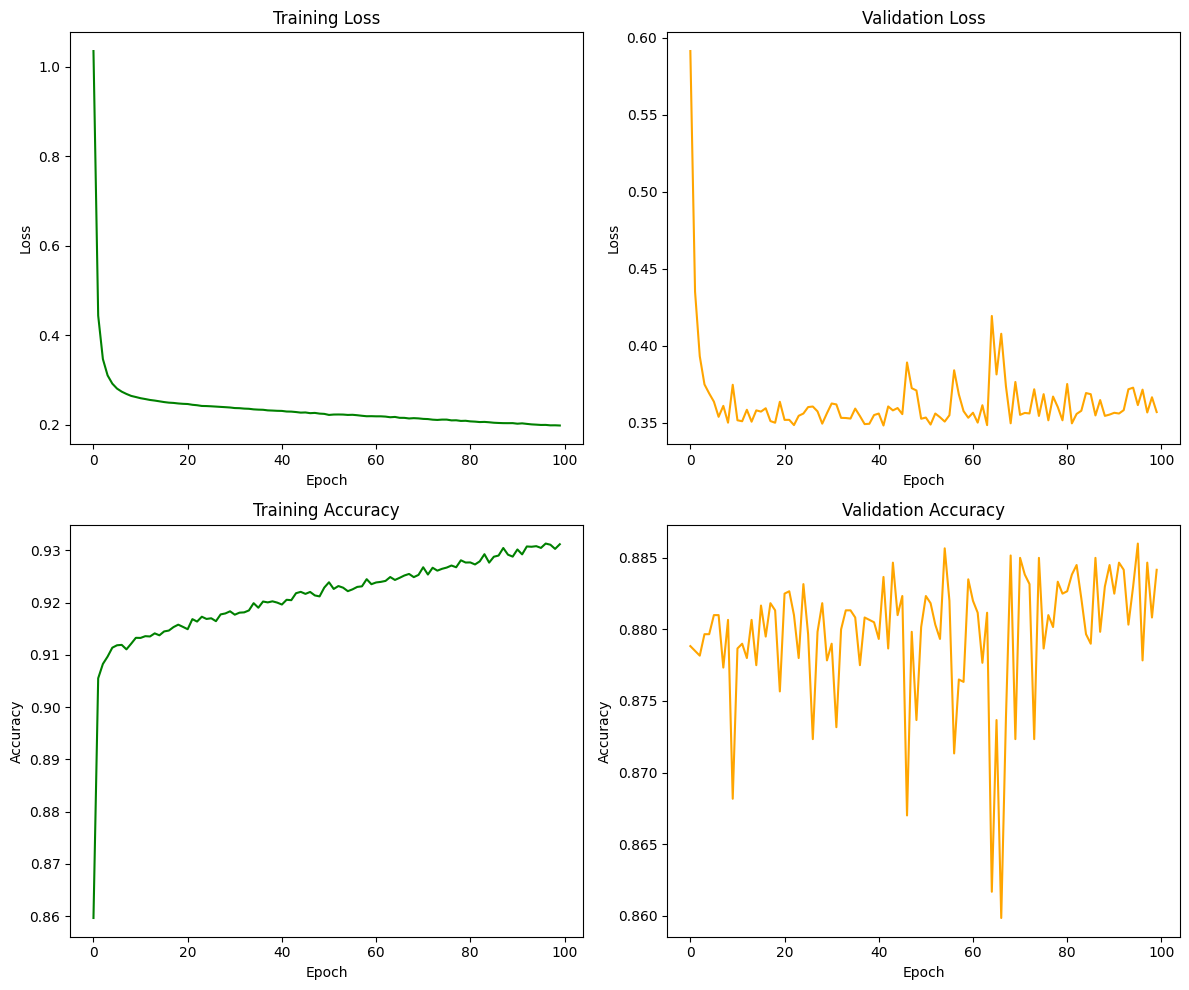

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Vẽ Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Vẽ Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Vẽ Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Vẽ Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


Đánh giá mô hình

In [24]:
test_target = []
test_predict = []

# Đặt mô hình ở chế độ đánh giá
model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)

        # Lưu lại dự đoán và nhãn thực tế
        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

# Ghép kết quả từ các batch thành một tensor duy nhất
test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)

# Tính toán độ chính xác
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

# In kết quả
print('Evaluation on test set:')
print(f'Accuracy: {test_acc:.4f}')


Evaluation on test set:
Accuracy: 0.8756
